In [1]:
import pandas as pd
import numpy as np
path='http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Electronics.csv'

df=pd.read_csv(path,names=['User_id','Product_ID','Rating','Timestamp'])

In [2]:
df=df.drop(['Timestamp'],axis=1)

#### Top Rated 10 products

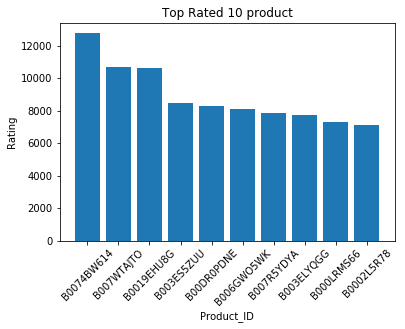

In [6]:
import matplotlib.pyplot as plt
TEMP_DF=pd.DataFrame()
# The data frame is for plotting purpose
TEMP_DF['Rating'] = df['Product_ID'].iloc[np.where(df['Rating']==5)].value_counts().head(10)
TEMP_DF['Product_ID']=TEMP_DF.index
plt.bar(TEMP_DF['Product_ID'],TEMP_DF['Rating'])

plt.xlabel('Product_ID', fontsize=10)
plt.ylabel('Rating', fontsize=10)
plt.xticks(TEMP_DF['Product_ID'], fontsize=10, rotation=45)
plt.title('Top Rated 10 product')
plt.show()

#### Most Rating Users

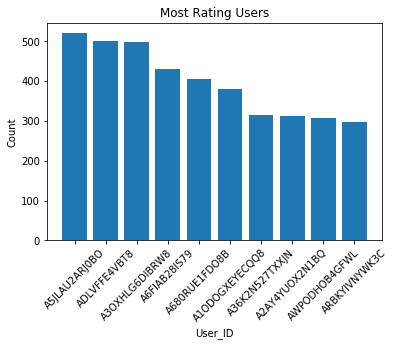

In [8]:
TEMP_DF=pd.DataFrame()
# The data frame is for plotting purpose
TEMP_DF['Count'] = df['User_id'].value_counts().sort_values(ascending=False).head(10)
TEMP_DF['User_ID']=TEMP_DF.index
plt.bar(TEMP_DF['User_ID'],TEMP_DF['Count'])

plt.xlabel('User_ID', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(TEMP_DF['User_ID'], fontsize=10, rotation=45)
plt.title('Most Rating Users')
plt.show()

Take a subset of the dataset to make it less sparse/ denser

In [9]:
Filter=df['User_id'].value_counts() >= 50
DF2=df.iloc[np.where(Filter)]

In [10]:
DF2.to_csv('Input.csv', index=False)

In [11]:
# Using a subset of Data to Analyse and Train the model
import pandas as pd
Ratings=pd.read_csv('Input.csv')
Ratings.shape

(1540, 3)

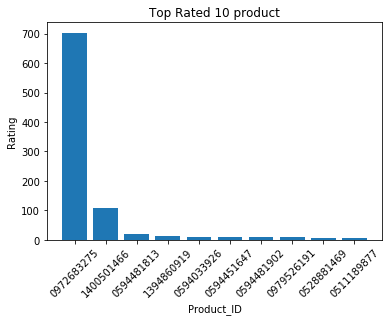

In [12]:
import matplotlib.pyplot as plt
import numpy as np
TEMP_DF=pd.DataFrame()
# The data frame is for plotting purpose
TEMP_DF['Rating'] = Ratings['Product_ID'].iloc[np.where(Ratings['Rating']==5)].value_counts().head(10)
TEMP_DF['Product_ID']=TEMP_DF.index
plt.bar(TEMP_DF['Product_ID'],TEMP_DF['Rating'])

plt.xlabel('Product_ID', fontsize=10)
plt.ylabel('Rating', fontsize=10)
plt.xticks(TEMP_DF['Product_ID'], fontsize=10, rotation=45)
plt.title('Top Rated 10 product')
plt.show()

In [14]:
### Inference: Product ID 0972683275 is top rated, with 700+ "5" ratings
Ratings[Ratings['Product_ID']=='0972683275'].groupby(['Product_ID','Rating']).count()

User_id
Product_ID Rating         
0972683275 1.0          32
           2.0          28
           3.0          56
           4.0         232
           5.0         703

#### Transforming data into Surprise format

In [15]:
from surprise import Dataset,Reader
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(Ratings[['User_id','Product_ID','Rating']], reader)

#### Choosing the Best Collaborative Filtering model

In [16]:
from surprise.model_selection.validation import cross_validate
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
benchmark = []

# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'],cv=5, verbose=False)
    
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Don

,test_rmse,fit_time,test_time
Algorithm,,,
KNNBaseline,1.164463,0.074351,0.003100
BaselineOnly,1.166173,0.004857,0.002597
SVD,1.170388,0.088445,0.002066
SVDpp,1.181292,0.167756,0.002360
KNNWithMeans,1.234611,0.072262,0.002443
KNNWithZScore,1.238256,0.120256,0.002939
CoClustering,1.239374,0.141566,0.001948
NMF,1.239758,0.178648,0.002296
KNNBasic,1.239759,0.060086,0.003335


In [17]:
# Split data to train and test
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.30,random_state=75)

In [18]:
print(trainset.to_raw_uid(0)) #User ID
print(trainset.to_raw_iid(1)) #Product ID
trainset.ur[1]

A6UFYXM3VDZ
0439886341


[(0, 5.0)]

In [19]:
# Training the model

In [20]:
from surprise import accuracy
from surprise import Prediction

model = KNNBaseline(k=40, min_k=1, sim_options={'name': 'pearson', 'user_based': False})
model.fit(trainset)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [21]:
len(testset)

462

In [22]:
# Evalute on test set
test_pred = model.test(testset)

# compute RMSE
accuracy.rmse(test_pred)

RMSE: 1.1724


1.1724307020571962

In [23]:
# convert results to dataframe
test_pred_df = pd.DataFrame(test_pred)
test_pred_df['est']=test_pred_df['est'].round(0)
# Check if the Predict and Actual values match
test_pred_df['Accuracy']=test_pred_df['r_ui'].equals(test_pred_df['est'])

In [24]:
test_pred_df.loc[test_pred_df['Accuracy']== False]
# test_pred_df

,uid,iid,r_ui,est,details,Accuracy
0,A2WI39Z73DBX1B,1400501466,5.0,4.0,{'was_impossible': False},False
1,A7NCGA42VJXSN,0972683275,5.0,4.0,{'was_impossible': False},False
2,A3VGRNJVUY5GD,0972683275,5.0,4.0,{'was_impossible': False},False
3,A3T1DE9OZLLLWG,0972683275,1.0,4.0,{'was_impossible': False},False
4,A3CAGSLL6VIX76,0972683275,5.0,4.0,{'was_impossible': False},False
5,A3OWMIJJB2NCDS,1094441252,5.0,4.0,{'was_impossible': False},False
6,A38T51B7J6QVD9,0594012015,1.0,4.0,{'was_impossible': False},False
7,A2LSIS2A2CNLVL,0972683275,4.0,4.0,{'was_impossible': False},False
8,AZM8PD2KBVXN5,0972683275,5.0,4.0,{'was_impossible': False},False
9,A2QXA14SNZTF65,0972683275,5.0,4.0,{'was_impossible': False},False


In [25]:
# Model failed to correctly predict the rating for 461 user id. 
# The ratings in the Test data set are different to the Training data set, hence model failed to make a right predict the right results
# build_anti_testset will find the ratings that are not in the training data set and create a test set out of it.

In [26]:
testset_new = trainset.build_anti_testset()
len(testset_new)

48510

In [27]:
predictions = model.test(testset_new[:])
predictions_df = pd.DataFrame([[x.uid,x.iid,x.est] for x in predictions])
predictions_df.columns = ["User_ID","Product_ID","est_rating"]
predictions_df.sort_values(by = ["User_ID", "est_rating"],ascending=False,inplace=True)

In [28]:
Recommendations = predictions_df.groupby("User_ID").head(5).reset_index(drop=True)

In [35]:
# Top5 product recommendations for a user (collabrative based Model)
Recommendations[['User_ID','Product_ID']].iloc[np.where(Recommendations['User_ID']=='AZTC7YC8PKG39')]

,User_ID,Product_ID
0,AZTC7YC8PKG39,0594033926
1,AZTC7YC8PKG39,1182702627
2,AZTC7YC8PKG39,059400232X
3,AZTC7YC8PKG39,0777700018
4,AZTC7YC8PKG39,0594033934


In [36]:
# Popularity Based Model
TEMP_DF=pd.DataFrame()
TEMP_DF['Rating'] = Ratings['Product_ID'].iloc[np.where(Ratings['Rating']==5)].value_counts().head(5)
TEMP_DF['Product_ID']=TEMP_DF.index
TEMP_DF.reset_index(drop=True,inplace=True)
TEMP_DF

,Rating,Product_ID
0,703,0972683275
1,109,1400501466
2,19,0594481813
3,13,1394860919
4,11,0594033926


Collabrative based model recommends, products to the users based on the products they have rated.
Popularity based model recommends, products based on the highest review ratings